<font size="6"> **Portfolio Optimization: Attribution and Results** </font>

In [1]:
%%capture
%run 00_portopt_data.ipynb

In [2]:
import datetime as dt

from tqdm import tqdm

from src.mle_quant_utils import portopt_utils
from src.portfolio_opt import cvx_opt_port

In [3]:
N_DAYS_DELAY = cfg['backtesting']['n_days_delay']
OPT_CONST = cfg['backtesting']['opt_port']
LAMBDA_REG = OPT_CONST['lambda_reg']

In [4]:
print('n_days_delay:', N_DAYS_DELAY)
print('opt constraints params:', OPT_CONST)

n_days_delay: 2
opt constraints params: {'risk_aversion': '1e-6', 'min_mkt_cap': '1e8', 'lambda_reg': '0.5', 'risk_cap': '0.05', 'factor_max': '10.0', 'factor_min': '-10.0', 'weights_max': '0.55', 'weights_min': '-0.55'}


In [5]:
INPATH1 =  os.path.join(io_utils.processed_path, cfg['output']['opt_portfolio']['folder'], OPT_MODEL_VERSION, "")
INPATH2 =  os.path.join(io_utils.models_path, cfg['output']['opt_portfolio']['folder'], OPT_MODEL_VERSION, "")
print(os.path.isdir(INPATH1), os.path.isdir(INPATH2))

True True


In [6]:
INFILE1 = cfg['output']['opt_portfolio']['pnl_results']
INFILE2 = cfg['output']['opt_portfolio']['model']
INFILE3 = cfg['output']['opt_portfolio']['model_metadata']

# Load Data

## Statistical Risk Model

In [7]:
risk_model.keys()

dict_keys(['idiosyncratic_var_vector', 'factor_var_vector', 'factor_betas', 'factor_returns'])

In [8]:
risk_model['factor_betas'].shape

(490, 20)

In [9]:
risk_model['factor_cov_matrix'] = np.diag(risk_model['factor_var_vector']['0'].values)
risk_model['factor_cov_matrix'].shape

(20, 20)

In [10]:
risk_model['idiosyncratic_var_vector'].shape

(490, 1)

## Alpha Factors

In [11]:
pd.concat([B_alpha.head(2), B_alpha.tail(2)], axis=0)


Mean_Reversion_Sector_Neutral_Smoothed  \
date                      asset                                           
2015-05-26 00:00:00+00:00 A                                    1.534003   
                          AAL                                  1.692444   
2015-12-28 00:00:00+00:00 ZION                                 0.773366   
                          ZTS                                 -0.944433   

                                 Momentum_1YR_Smoothed  \
date                      asset                          
2015-05-26 00:00:00+00:00 A                  -1.233543   
                          AAL                 0.236520   
2015-12-28 00:00:00+00:00 ZION               -0.188031   
                          ZTS                 0.209727   

                                 Overnight_Sentiment_Smoothed  \
date                      asset                                 
2015-05-26 00:00:00+00:00 A                          1.149941   
                          AAL                        1.664201   
2015-12-28 00:00:00+00:00 ZION                       1.325552   
                          ZTS                        0.441851   

                                 avg_combi_alpha  ml_alpha  
date                      asset                             
2015-05-26 00:00:00+00:00 A             0.483467  1.508204  
                          AAL           1.197722  2.995088  
2015-12-28 00:00:00+00:00 ZION          0.636962  1.059585  
                          ZTS          -0.097619 -0.273877

## PnL Data

In [12]:
pnl_app = pd.read_csv(INPATH1 + INFILE1, parse_dates=['date'])
pnl_app.set_index(inplace=True, keys=['date', 'port_name'])
pd.concat([pnl_app.head(2), pnl_app.tail(2)], axis=0)

,,returns_date,daily_pnl,daily_transaction_cost,daily_total,accum_total,accum_transaction_cost
date,port_name,,,,,,
2015-05-26 00:00:00+00:00,simple_ml,2015-05-28 00:00:00+00:00,0.001652,0.000000e+00,0.001652,0.001652,0.000000
2015-05-27 00:00:00+00:00,simple_ml,2015-05-29 00:00:00+00:00,0.001363,0.000000e+00,0.001363,0.003015,0.000000
2015-12-22 00:00:00+00:00,tc_avg_combi,2015-12-24 00:00:00+00:00,-0.001911,4.571629e-07,-0.001911,0.038125,0.000070
2015-12-23 00:00:00+00:00,tc_avg_combi,2015-12-28 00:00:00+00:00,0.003345,3.887931e-07,0.003345,0.041470,0.000071


In [13]:
pnl_app.groupby(level=1)[['daily_pnl', 'daily_transaction_cost']].describe()

daily_pnl                                                    \
                     count      mean       std       min       25%       50%   
port_name                                                                      
simple_avg_combi     149.0  0.000279  0.003982 -0.011773 -0.002395  0.000589   
simple_ml            149.0  0.000293  0.003797 -0.009261 -0.002145  0.000057   
tc_avg_combi         149.0  0.000279  0.003982 -0.011773 -0.002395  0.000589   
tc_ml                149.0  0.000293  0.003797 -0.009261 -0.002145  0.000057   

                                     daily_transaction_cost                \
                       75%       max                  count          mean   
port_name                                                                   
simple_avg_combi  0.003313  0.009001                  149.0  0.000000e+00   
simple_ml         0.003133  0.010148                  149.0  0.000000e+00   
tc_avg_combi      0.003313  0.009001                  149.0  4.746810e-07   
tc_ml             0.003133  0.010148                  149.0  6.516188e-07   

                                                                          \
                           std           min           25%           50%   
port_name                                                                  
simple_avg_combi  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
simple_ml         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
tc_avg_combi      9.378328e-08  2.959222e-07  4.071318e-07  4.647332e-07   
tc_ml             2.018261e-07  3.515013e-07  5.333180e-07  6.213590e-07   

                                              
                           75%           max  
port_name                                     
simple_avg_combi  0.000000e+00  0.000000e+00  
simple_ml         0.000000e+00  0.000000e+00  
tc_avg_combi      5.214970e-07  8.493941e-07  
tc_ml             7.062863e-07  1.624114e-06

In [14]:
pnl_app['total_transaction_cost'] = pnl_app.groupby(level=0)['daily_transaction_cost'].cumsum()

In [15]:
pnl_tc_ml = pnl_app.xs(level=1, key='tc_ml').copy()
pnl_tc_avg_combi = pnl_app.xs(level=1, key='tc_avg_combi').copy()

In [16]:
pnl_tc_ml

,returns_date,daily_pnl,daily_transaction_cost,daily_total,accum_total,accum_transaction_cost,total_transaction_cost
date,,,,,,,
2015-05-26 00:00:00+00:00,2015-05-28 00:00:00+00:00,0.001652,6.792129e-07,0.001651,0.001651,6.792129e-07,6.792129e-07
2015-05-27 00:00:00+00:00,2015-05-29 00:00:00+00:00,0.001363,6.123120e-07,0.001362,0.003014,1.291525e-06,6.123120e-07
2015-05-28 00:00:00+00:00,2015-06-01 00:00:00+00:00,0.003884,5.147963e-07,0.003884,0.006897,1.806321e-06,5.147963e-07
2015-05-29 00:00:00+00:00,2015-06-02 00:00:00+00:00,-0.001204,6.036218e-07,-0.001205,0.005693,2.409943e-06,6.036218e-07
2015-06-01 00:00:00+00:00,2015-06-03 00:00:00+00:00,0.002147,7.060076e-07,0.002146,0.007839,3.115950e-06,7.060076e-07
...,...,...,...,...,...,...,...
2015-12-17 00:00:00+00:00,2015-12-21 00:00:00+00:00,0.006552,3.561081e-07,0.006551,0.052298,9.513537e-05,3.561081e-07
2015-12-18 00:00:00+00:00,2015-12-22 00:00:00+00:00,-0.005209,3.954979e-07,-0.005209,0.047088,9.553087e-05,3.954979e-07
2015-12-21 00:00:00+00:00,2015-12-23 00:00:00+00:00,0.000883,3.771029e-07,0.000883,0.047971,9.590798e-05,3.771029e-07


## Daily Portfolio weights

In [17]:
with open(INPATH2 + f'{INFILE2}', 'rb') as file:
    models_dict = pickle.load(file)
models_dict.keys()
simple_ml_avg_combi  = models_dict['simple_ml_avg_combi']
simple_ml = models_dict['simple_ml']
tc_avg_combi = models_dict['tc_avg_combi']
tc_ml = models_dict['tc_ml']

In [18]:
with open(INPATH2 + f'{INFILE3}', 'rb') as file:
    opt_metadata = pickle.load(file)
opt_metadata

{'alpha_model': 'v01',
 'risk_model': 'v01',
 'opt_constraints': {'risk_aversion': '1e-6',
  'min_mkt_cap': '1e8',
  'lambda_reg': '0.5',
  'risk_cap': '0.05',
  'factor_max': '10.0',
  'factor_min': '-10.0',
  'weights_max': '0.55',
  'weights_min': '-0.55'},
 'backtesting_start_dt': '2015-05-26',
 'backtesting_end_dt': '2015-12-28',
 'n_days_delay': 2}

# Bencharking

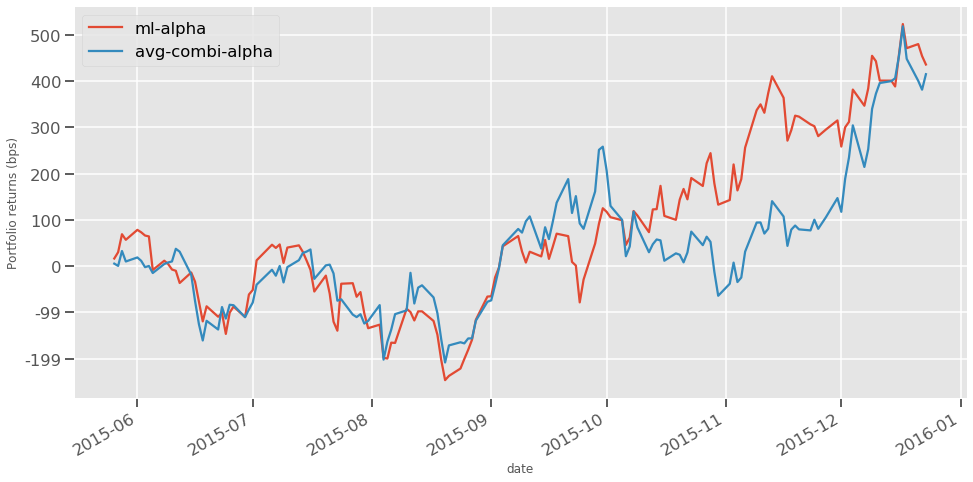

In [46]:
ax = pnl_tc_ml.plot(y='accum_total', label='ml-alpha')
pnl_tc_avg_combi.plot(ax=ax, y='accum_total', label='avg-combi-alpha')

# manipulate

ax.set_yticklabels([int(x) for x in ax.get_yticks()*1e4])

plt.ylabel("Portfolio returns (bps)")
plt.show()

In [47]:
pnl_sharpe = pnl_app.groupby(level=1)['daily_total'].apply(lambda grp: portopt_utils.sharpe_ratio(grp, ann_period=252))
pnl_sharpe

port_name
simple_avg_combi    1.111504
simple_ml           1.224815
tc_avg_combi        1.109611
tc_ml               1.222112
Name: daily_total, dtype: float64